# Rossmann Store Sales

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You can download the dataset here: https://www.kaggle.com/c/rossmann-store-sales/data.

Business understanding:

* What is the motivation?

    * Sales prediction was required by the CFO in a monthly meeting about stores results.

* What is the root cause of the problem?

    * Dificulty when deciding investiment values for remodeling each store.

* Who is the problem owner?

    * Rossmann's Financial Director (CFO).

* How will the solution be?

    * Granularity: sales prediction for each store for the next 6 weeks (42 days)
    
    * Problem type: sales prediction
    
    * Methods: timeseries, regression
    
    * Delivery: total sales for each store at the end of 6 weeks, following the results daily

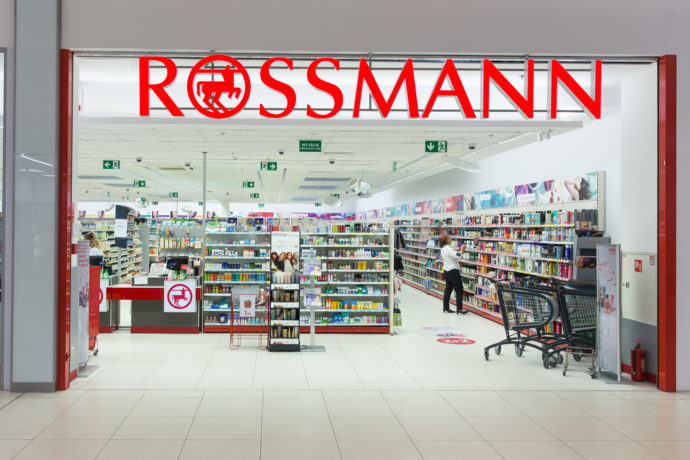

**Table of contents:**

1. [Imports](#imports) <br>
    1.1. [Helper Functions](#helper_functions)<br>
    1.2. [Loading Data](#loading_data)<br>
2. [Data Description](#data_description)<br>
    2.1. [Rename Columns](#rename_columns)<br>
    2.2. [Data Dimensions](#data_dimensions)<br>
    2.3. [Data Types](#data_types)<br>
    2.4. [Check NA](#check_na)<br>
    2.5. [Fillout NA](#fillout_na)<br>
    2.6. [Change Data Types](#change_data_types)<br>
    2.7. [Descriptive Statistical](#descriptive_statistical)<br>
3. [Feature Engineering](#feature_engineering)<br>
    3.1. [Hypothesis Creation](#hypothesis_creation)<br>
    3.2. [Final Hypothesis List](#final_hypothesis_list)<br>
    3.2. [New Features](#new_features)<br>
4. [Data Filtering](#data_filtering)<br>
    4.1. [Rows Filtering](#rows_filtering)<br>
    4.2. [Columns Selection](#columns_selection)<br>
5. [Exploratory Data Analysis](#exploratory_data_analysis)<br>
    5.1. [Univariate Analysis](#univariate_analysis)<br>
    5.2. [Bivariate Analysis](#bivariate_analysis)<br>
    5.3. [Multivariate Analysis](#multivariate_analysis)<br>

# 1. Imports <a id='imports'></a>

In [1]:
import pandas as pd
import inflection
import numpy as np
import datetime
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display  import HTML

## 1.1. Helper Functions <a id='imports'></a>

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.max_columns', None)
    
    sns.set()

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    chi2 = stats.chi2_contingency( cm )[0]
    n = cm.sum()
    r, k = cm.shape
    
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2/n)/ (min(kcorr-1,rcorr-1)))

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.2. Loading Data <a id='loading_data'></a>

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')
df_raw.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


# 2. Data Description <a id='data_description'></a>

In [5]:
df1 = df_raw.copy()

## 2.1. Rename Columns <a id='rename_columns'></a>

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 2.2. Data Dimensions<a id='data_dimensions'></a>

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 2.3. Data Types<a id='data_types'></a>

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
# changing date to datetime type
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4. Check NA<a id='check_na'></a>

In [10]:
df1.isna().sum().sort_values(ascending = False)

promo_interval                  508031
promo2_since_year               508031
promo2_since_week               508031
competition_open_since_year     323348
competition_open_since_month    323348
competition_distance              2642
day_of_week                          0
promo2                               0
assortment                           0
store                                0
school_holiday                       0
state_holiday                        0
promo                                0
open                                 0
customers                            0
sales                                0
date                                 0
store_type                           0
dtype: int64

## 2.5. Fillout NA<a id='fillout_na'></a>

* competition_distance

    * Shows distance in meters to nearest competitor store. If a value is null, it should mean that there are no near competitors. Thus, this columns will be filled with 200000, much higher than the maximun competion_distance value in the dataset
    
* competition_open_since_[month/year]

    * Gives the approximate year and month of the time the nearest competitor was opened. NaN values will be replaced with the month and year that was filled in the date column.
    
* promo2_since_[year/week]

    * Describes the year and calendar week when the store started participating in promo2, which is a continuing and consecutive promotion for some stores. NaN values will be replaced with the month and year that was filled in the date column.
    
* promo_interval
    
    * Describes the consecutive intervals promo2 is started, naming months the promotion is started anew. E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store. NaN values are replaced with 0 and checked if the store participated in promo2 or not represented by 0 and 1 in a column named is_promo.  

In [11]:
# competition_distance
df1['competition_distance'].fillna(200000, inplace = True)

# competition_open_since_month
df1['competition_open_since_month'].fillna(df1['date'].dt.month, inplace = True)

# competition_open_since_year
df1['competition_open_since_year'].fillna(df1['date'].dt.year, inplace = True)

# promo2_since_week
df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week, inplace = True)

# promo2_since_year
df1['promo2_since_year'].fillna(df1['date'].dt.year, inplace = True)

# promo_interval -> is_promo
month_map = {1 : 'Jan', 2 : 'Fev', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 
 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [12]:
df1.isna().sum().sort_values(ascending = False)

store                           0
day_of_week                     0
month_map                       0
promo_interval                  0
promo2_since_year               0
promo2_since_week               0
promo2                          0
competition_open_since_year     0
competition_open_since_month    0
competition_distance            0
assortment                      0
store_type                      0
school_holiday                  0
state_holiday                   0
promo                           0
open                            0
customers                       0
sales                           0
date                            0
is_promo                        0
dtype: int64

## 2.6. Change Data Types<a id='change_data_types'></a>

In [13]:
# competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype("int64")
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype("int64")

# promo
df1['promo2_since_week'] = df1['promo2_since_week'].astype("int64")
df1['promo2_since_year'] = df1['promo2_since_year'].astype("int64")

## 2.7. Descriptive Statistical<a id='descriptive_statistical'></a>

A quick overview in numerical and categorical attributes.

In [14]:
# separating numeric and categoric features
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 2.7.1. Numerical Attributes<a id='numerical_attributes'></a>

* Central tendency
    * mean
    * median
* Dispersion
    * std - standard deviation
    * min
    * max
    * range
    * skew
        * skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean
    * kurtosis
        * measure of the "tailedness" of the probability distribution of a real-valued random variable

In [15]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

metrics = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
metrics.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Evaluating "sales" column:

* Min = 0, means that on that day the store was closed.
* Max = 41551
* Range = 451151 - 0
* Mean = It tells us that on average, 5773 sales are made per day.
* Median = Median very close to the average
* Std = Tell us that our sales may vary by +/- 3849, that is, there are days that total sales are (5773 + 3849) and there are days that total sales are (5773 - 3849)
* Skew = Positive and near to 0, slightly concentrated on the left side 
* Kurtosis = Positive value, indicating that data is more concentrated next to the mean

### 2.7.2. Categorical Attributes<a id='categorical_attributes'></a>

Boxplot

* Shows quantiles (25%, 50%, 75%)
* Max value = Q3 + 1.5 * IQ, where IQ = Q3 - Q1
* Min value = Q1 - 1.5 * IQ, where IQ = Q3 - Q1

Every data point above the max value or under the min value represents a outlier.

In [16]:
# get unique attributes from features
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

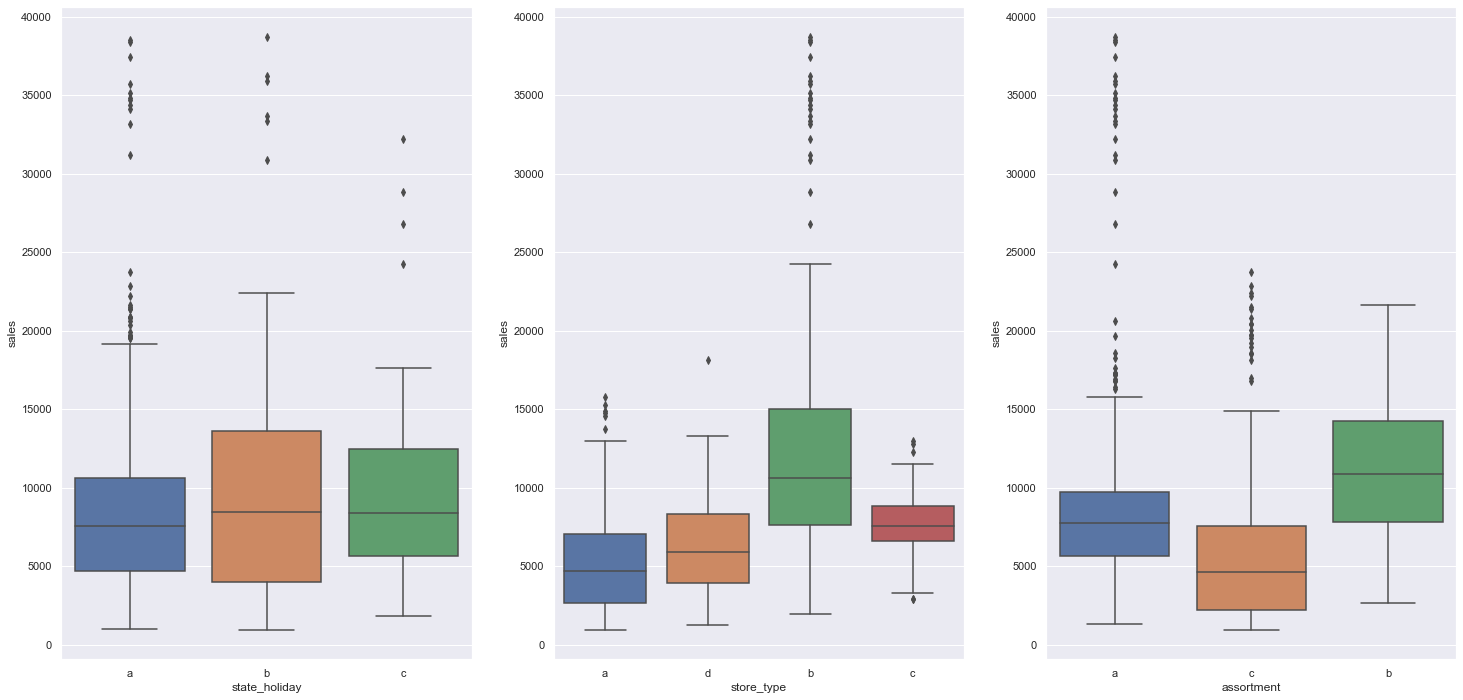

In [17]:
# boxplot
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 )]

fig, axes = plt.subplots(1, 3)
_ = sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1, ax = axes[0])

_ = plt.subplot(1,3,2)
_ = sns.boxplot(x = 'store_type',y = 'sales', data = aux1, ax = axes[1])

_ = plt.subplot(1,3,3)
_ = sns.boxplot(x = 'assortment', y = 'sales', data = aux1, ax = axes[2])

Some inferences from the data:

* state_holiday \\(\rightarrow\\) Holiday "b" has a median higher than "a" but very similar to "c".
* store_type \\(\rightarrow\\) type of store "b" has a lot more outliers and a larger amount of sales. Store "b" has a very large amount of data around the median. "a" and "d" have a similar dispersion around the median.
* assortment \\(\rightarrow\\) "b" has more sales compared to other types of assortment

# 3. Feature Engineering<a id='feature_engineering'></a>

* What's the phenomenon that we are modelling?
    * Sales
* What's the agent descriptions?
    * Age, Sex, Job

In [18]:
df2 = df1.copy()

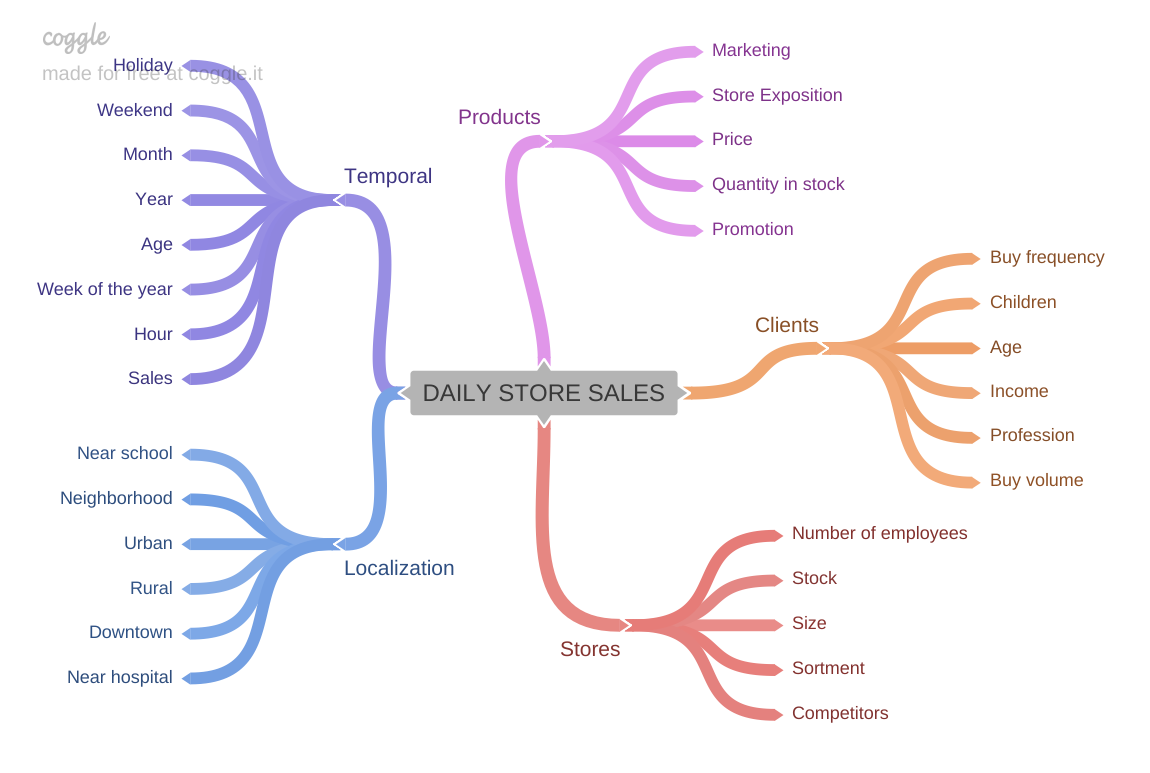

## 3.1. Hypotheses Creation<a id='hypothesis_creation'></a>

### 3.1.1. Store's Hypotheses<a id='stores_hypothesis'></a>

**1.** Stores with a larger workforce should sell more.

**2.** Stores with a larger stock should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less

**6.** Stores with longer competitors should sell more

### 3.1.2. Product's Hypotheses<a id='products_hypothesis'></a>

**1.** Stores that invest more in marketing should sell more.

**2.** Stores that exhibit more product in store windows should sell more.

**3.** Stores that have lower prices should sell more.

**4.** Stores that have more aggressive promotions (bigger discounts), should sell more

**5.** Stores that have prices less for longer products should sell more.

**6.** Stores with more promotion days should sell more

**7.** Stores with more consecutive promotions should sell more.

### 3.1.3. Time's Hypotheses<a id='times_hypothesis'></a>

**1.** Stores opened during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 3.2. Final Hypotheses List<a id='final_hypothesis_list'></a>

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores that have prices less for longer products should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 3.3. New features<a id='new_features'></a>

Aiming to validate the hypotheses, the following features are created:

* year
* month
* day
* week of day
* year week \\(\rightarrow\\) year and week in the format "2019-22"

In [19]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment 
#a = basic, b = extra, c = extended
assortment = {'a' : 'basic', 'b' : 'extra', 'c' : 'extended'}
df2['assortment'] = df2['assortment'].map(assortment)

#state_holiday
#a = public_holiday, b = easter_holiday, c = christmas, 0 = regular_day
state_holiday = {'a' : 'public_holiday', 'b' : 'easter_holiday', 'c' : 'christmas', '0' : 'regular_day'}
df2['state_holiday'] = df2['state_holiday'].map(state_holiday)

# 4. Data Filtering<a id='data_filtering'></a>

The data is commonly filtered due to business restrictions.

In [20]:
df3 = df2.copy()

## 4.1. Rows Filtering <a id='rows_filtering'></a>

Here, the rows where the store is closed or the sales were 0 at that day will be removed from the dataset.

In [21]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 4.2. Columns Selection <a id='columns_selection'></a>

The following columns will be droped:

**1.** Customer: As we will not have the number of customers to predict the future sales, it will be droped. A new model could be created to predict this variable.

**2.** Open: Since all the closed stores were removed, this column can be droped.

**3.** Promo_interval / month_map: From these features, the column "is_promo" was created. Then, they can be droped.

In [22]:
df3.drop(columns = ['customers','open','promo_interval','month_map'], axis = 1, inplace = True)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 5. Exploratory Data Analysis<a id='exploratory_data_analysis'></a>

* Univariate Analysis
    * Min, max, range, distribution
* Bivariate Analysis
    * How the feature impacts the target?
    * Correlation, hypothesis testing
* Multivariate Analysis
    * How the features are related to each other?
    * Correlation

In [23]:
df4 = df3.copy()

## 5.1. Univariate Analysis<a id='univariate_analysis'></a>

### 5.1.1. Response Variable

The sales distribution is shifted to the left, meaning it has positive skewness. It is important to know since many machine learning models work better with normal distributions.

D:\Anaconda\envs\rossmann\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


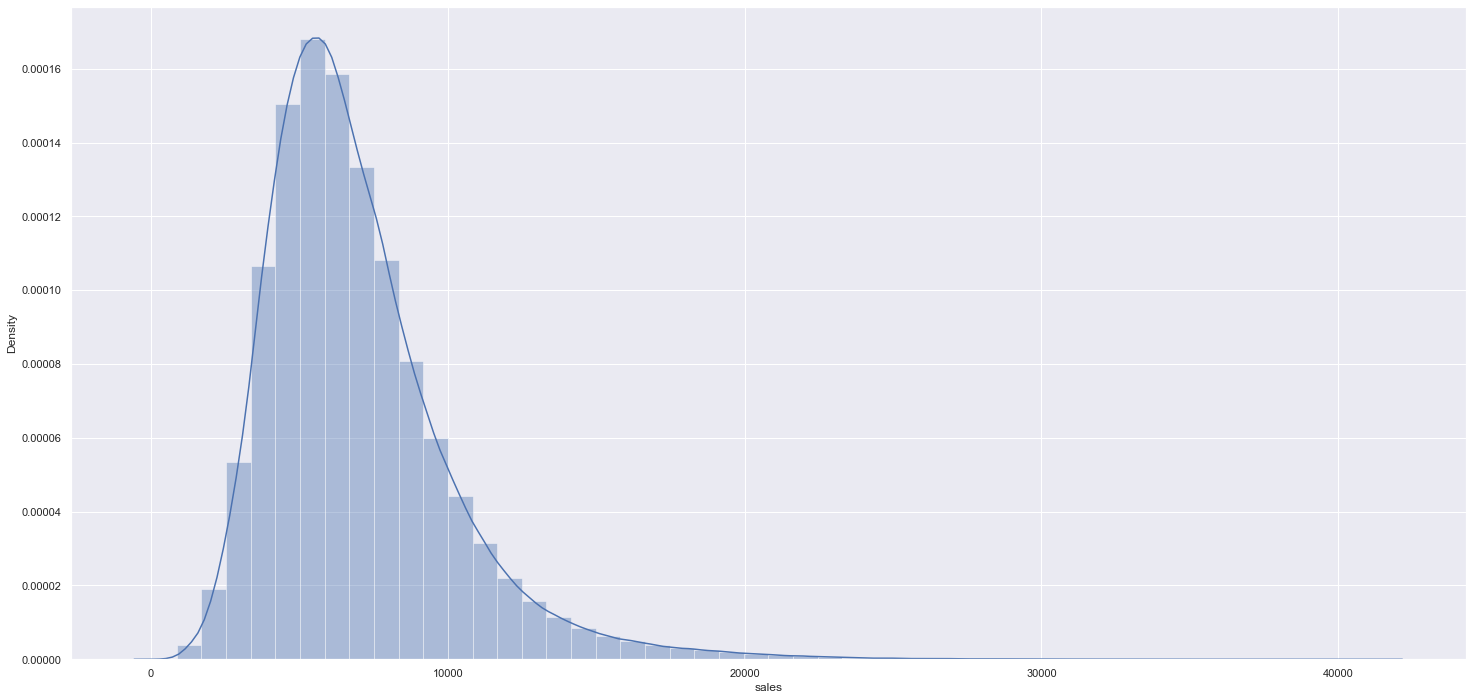

In [24]:
_ = sns.distplot(df4['sales'])

### 5.1.2. Numerical Variable

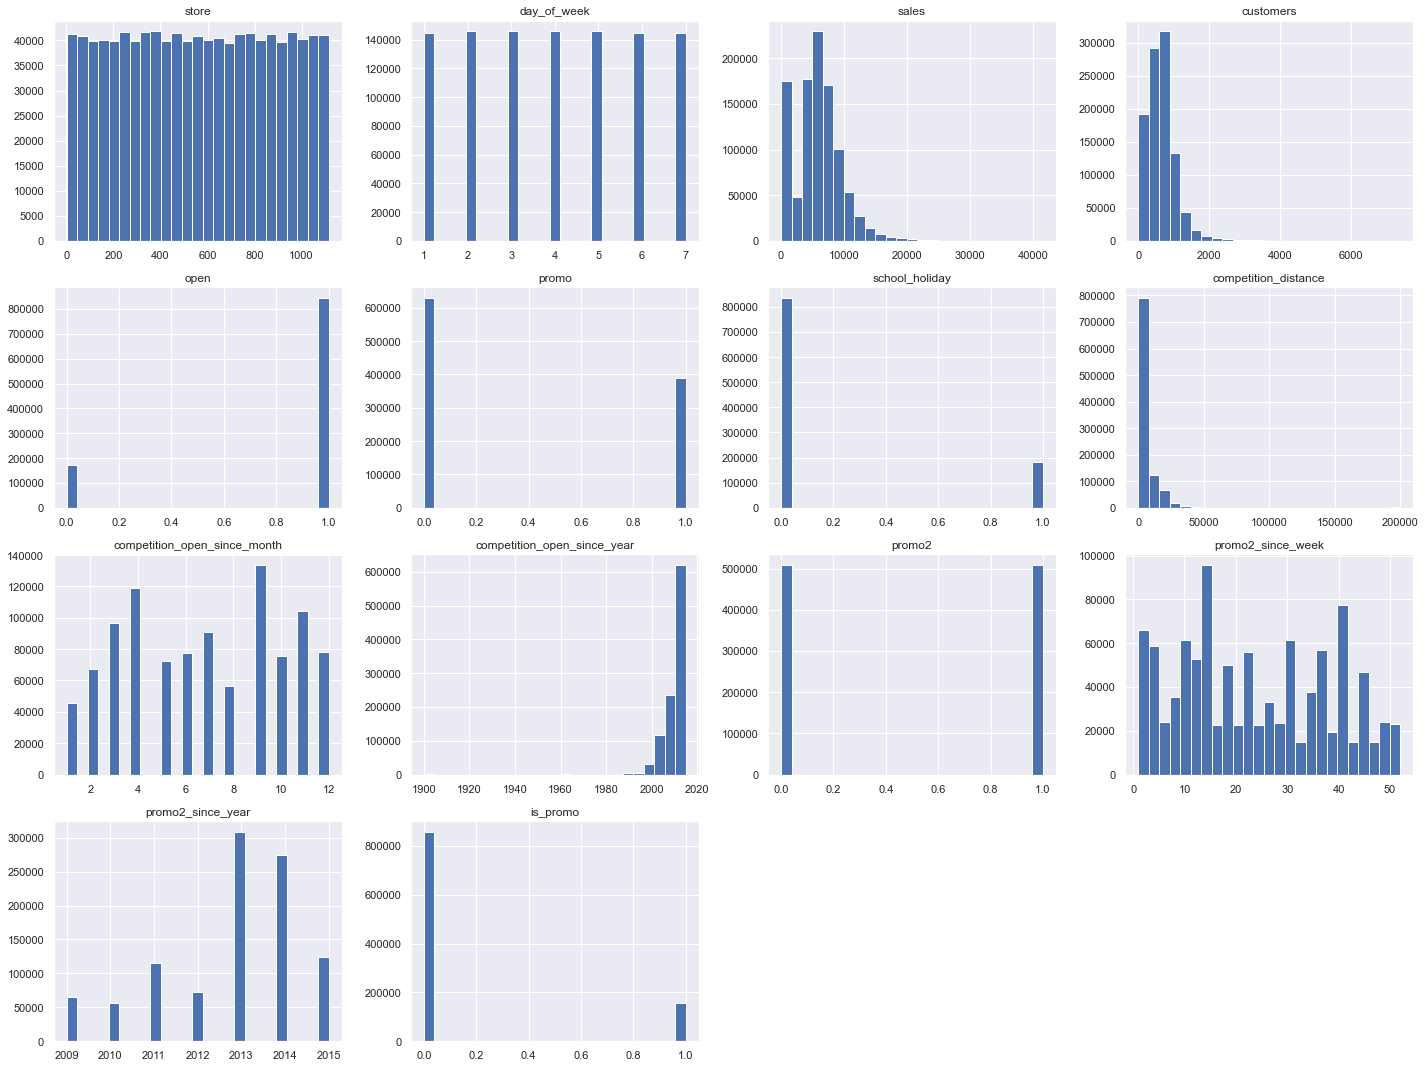

In [25]:
_ = num_attributes.hist(bins = 25, figsize = (20,15))
_ = plt.tight_layout()

From the graphs above, we can get some conclusions:

* **competition_distance** \\(\rightarrow\\) bigger concentrations in smaller intervals. So, there's a lot of close competitors.

* **competition_open_since_month** \\(\rightarrow\\) has an increase until the fourth month and reaches the maximum. From that there is a fall. Therefore, this feature has a certain variation.

* **day_of_week** \\(\rightarrow\\) there is no variation, so, the day of the week will not influence sales. There is no variation.

* **is_promo** \\(\rightarrow\\) there are a lot more sales when there are no promotions. This can be an insight, we will check soon.

* **promo2_since_year** \\(\rightarrow\\) there is a very high peak in 2013, we need to check what happened that year.

### 5.1.3. Categorical Variable

In [26]:
df4.select_dtypes(include = 'object').columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

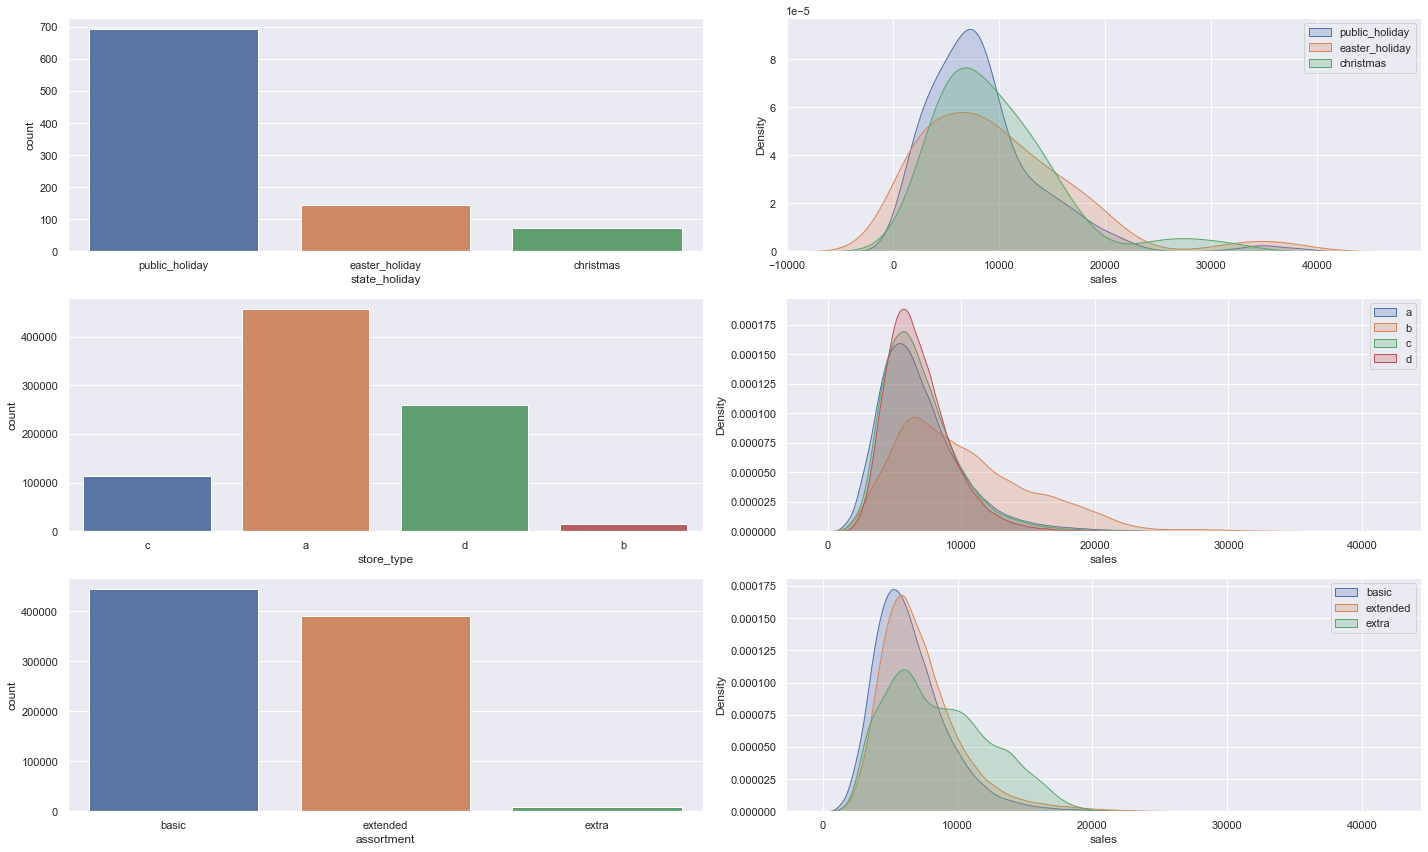

In [27]:
fig, axes = plt.subplots(3,2, figsize  = (20,12))

#state_holiday
a = df4[df4['state_holiday'] != 'regular_day']

sns.countplot(x = a['state_holiday'], ax = axes[0][0])

sns.kdeplot(x = df4[df4['state_holiday'] == 'public_holiday']['sales'],label = 'public_holiday',shade = True, ax = axes[0][1])
sns.kdeplot(x = df4[df4['state_holiday'] == 'easter_holiday']['sales'],label = 'easter_holiday',shade = True, ax = axes[0][1])
sns.kdeplot(x = df4[df4['state_holiday'] == 'christmas']['sales'],label = 'christmas',shade = True, ax = axes[0][1])

#store_type
sns.countplot(x = df4['store_type'], ax = axes[1][0])

sns.kdeplot(x = df4[df4['store_type'] == 'a']['sales'],label = 'a',shade = True, ax = axes[1][1])
sns.kdeplot(x = df4[df4['store_type'] == 'b']['sales'],label = 'b',shade = True, ax = axes[1][1])
sns.kdeplot(x = df4[df4['store_type'] == 'c']['sales'],label = 'c',shade = True, ax = axes[1][1])
sns.kdeplot(x = df4[df4['store_type'] == 'd']['sales'],label = 'd',shade = True, ax = axes[1][1])

#assortment
sns.countplot(x = df4['assortment'], ax = axes[2][0])

sns.kdeplot(x = df4[df4['assortment'] == 'basic']['sales'], label  = 'basic', shade = True, ax = axes[2][1])
sns.kdeplot(x = df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True, ax = axes[2][1])
sns.kdeplot(x = df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True, ax = axes[2][1])

# final configurations to the plots
axes[0][1].legend()
axes[1][1].legend()
axes[2][1].legend()
plt.tight_layout()
plt.show()

From all the plots above, we can get some conclusions:

* **state_holiday** \\(\rightarrow\\) there are a much larger amount of sales on public holidays, but at Christmas, which has a smaller amount of sales than easter_holiday, it has a higher peak.

* **store_type** \\(\rightarrow\\) The store_type "a" that sells more, does not have such a peak compared to the others.

* **assortment** \\(\rightarrow\\) stores with the "extra" type assortment sell less, but have a higher distribution. So, there are stores that sell more with the "extra" assortment and stores that sell less.

## 5.2. Bivariate Analysis<a id='bivariate_analysis'></a>

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

### H1. Stores with a larger assortment should sell more.¶

**False**. Stores with a larger assortment sell less.

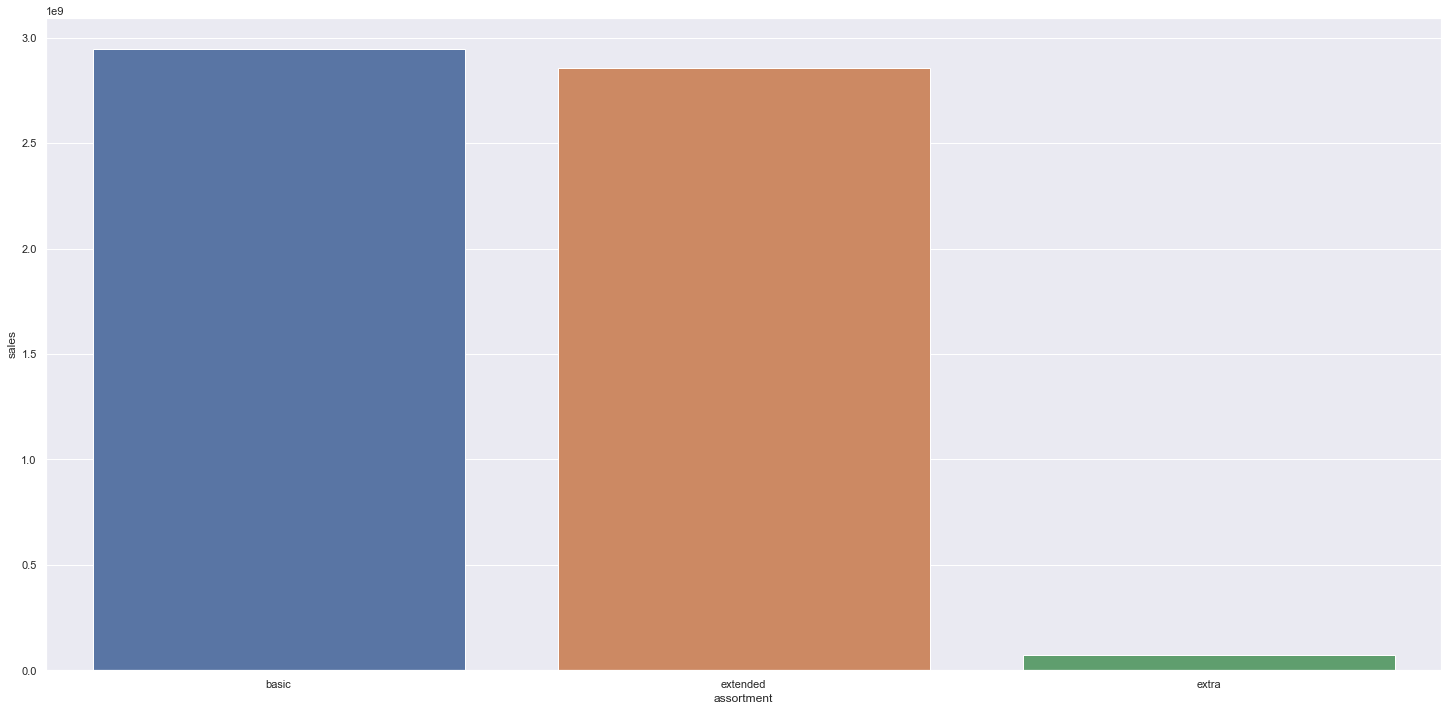

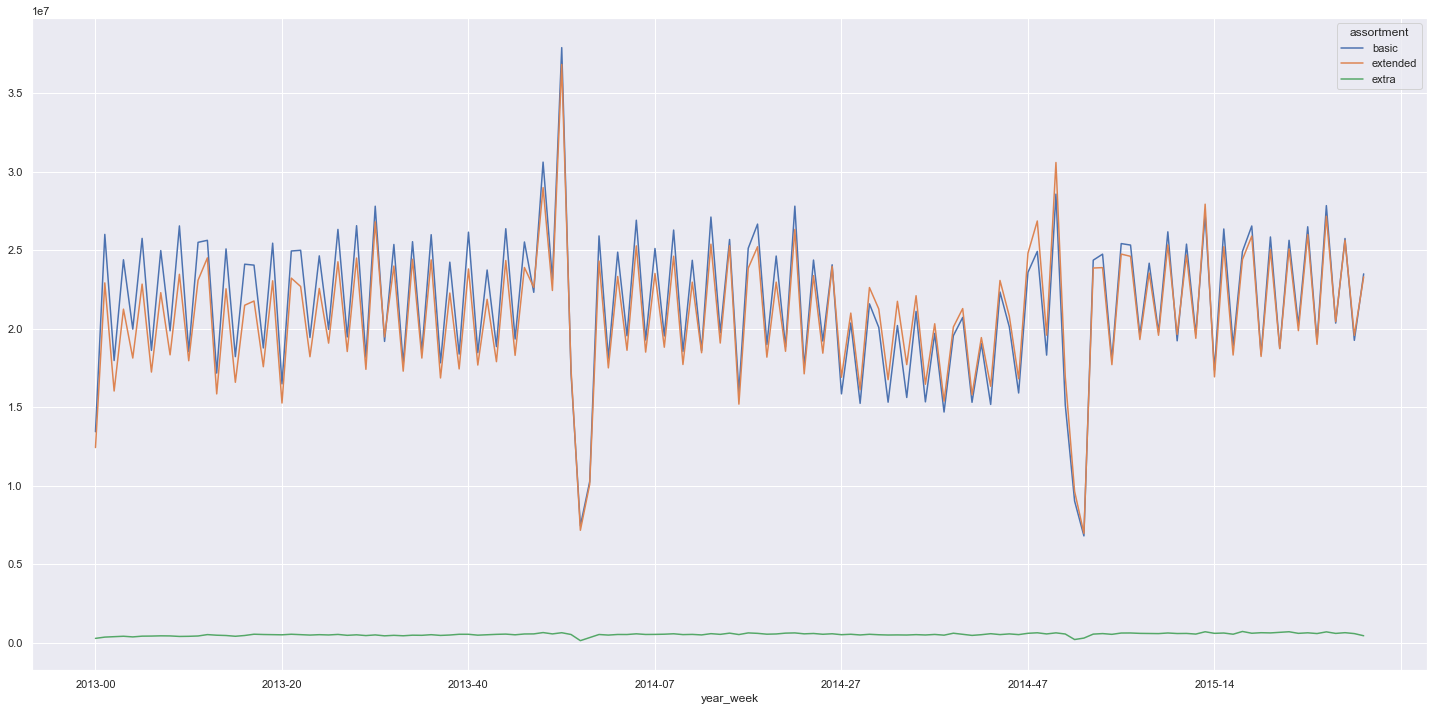

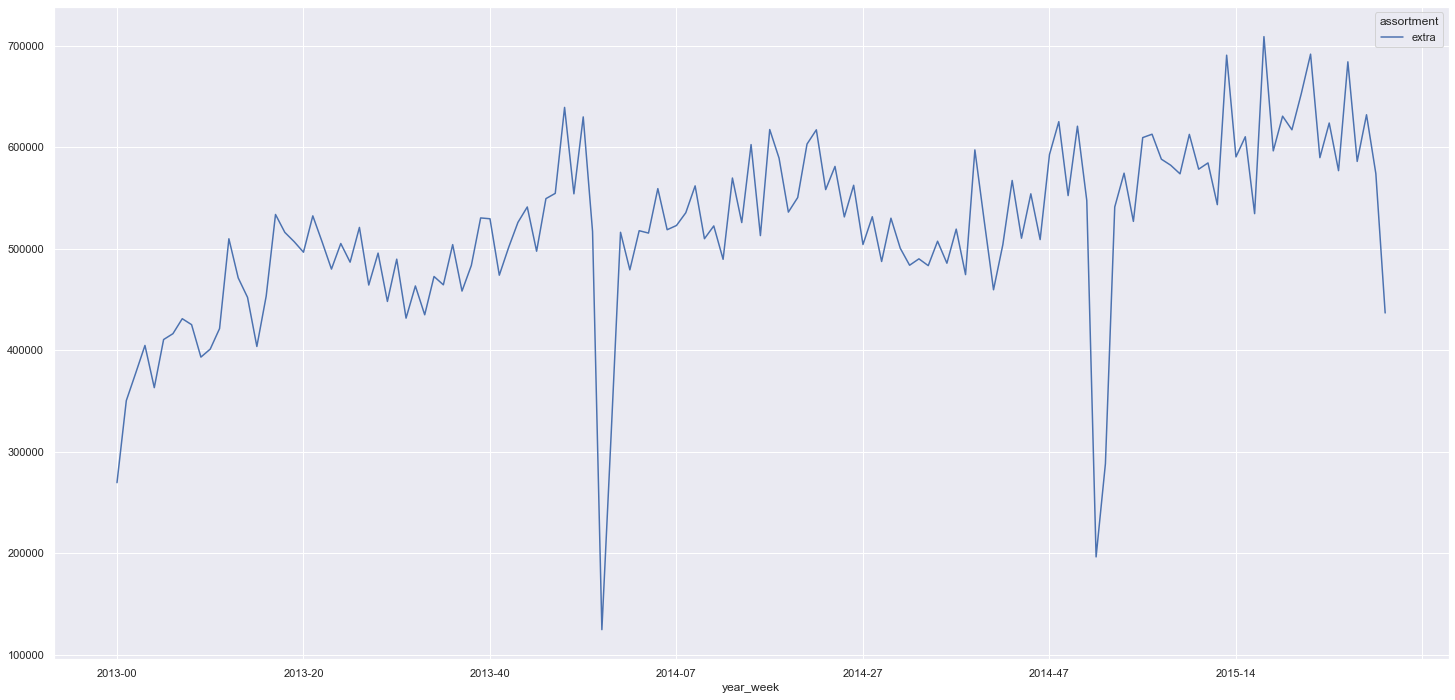

In [28]:
# barplot to check each assortment class count
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

# check by year_week each assortment sales
aux2 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux3 = aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales')
aux3.plot();

# check extra assortment sales
aux4 = aux2[aux2['assortment'] == 'extra']
aux4 = aux4.pivot(index = 'year_week',columns = 'assortment', values = 'sales')
aux4.plot();

### H2. Stores with closer competitors sell less

**False**. Stores with closer competitors sell more.

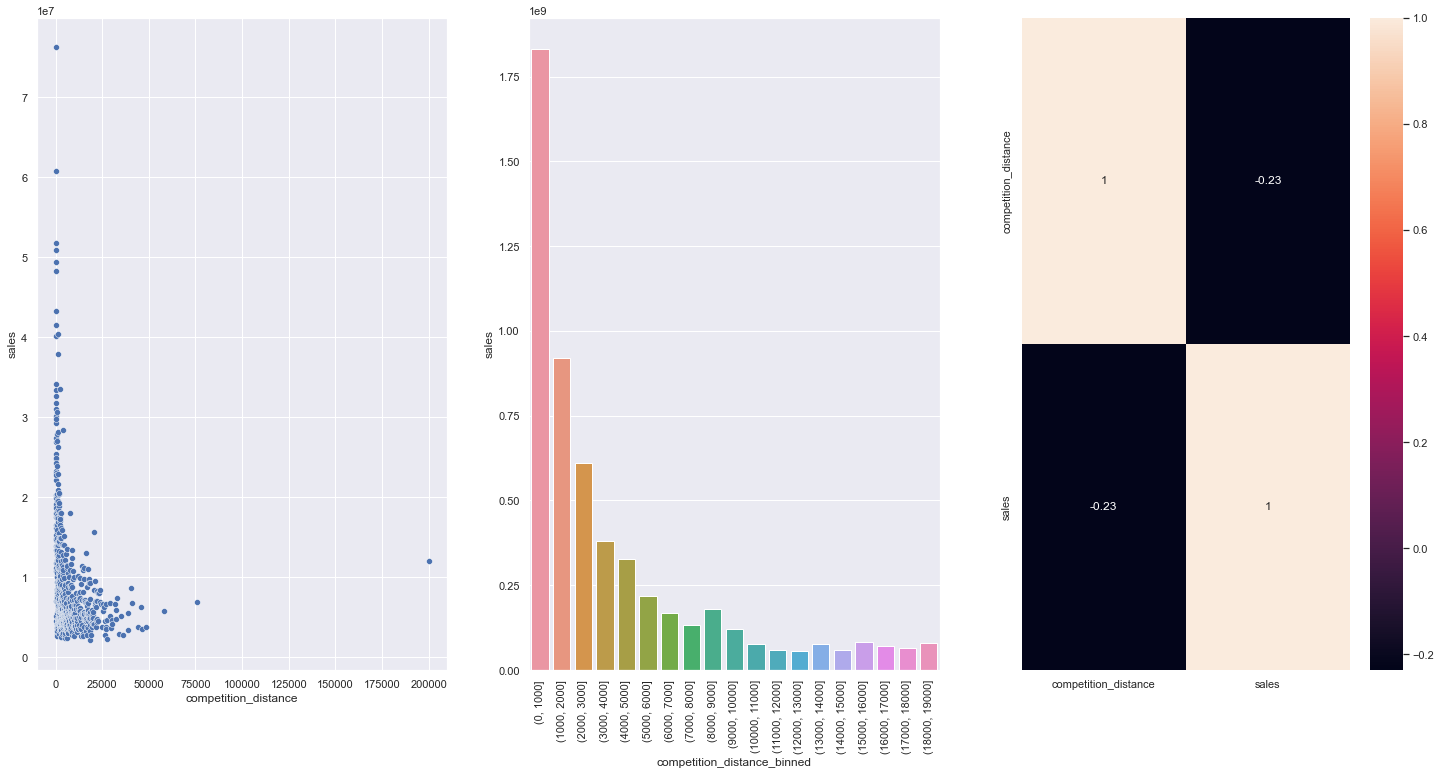

In [29]:
# scatter plot sales x competition distance
plt.subplot(1,3,1)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

# barplot with bins
plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90)
    
# correlation heatmap
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H3. Stores with long time competitors should sell more.

**False**. Stores with long time competitors sell less.

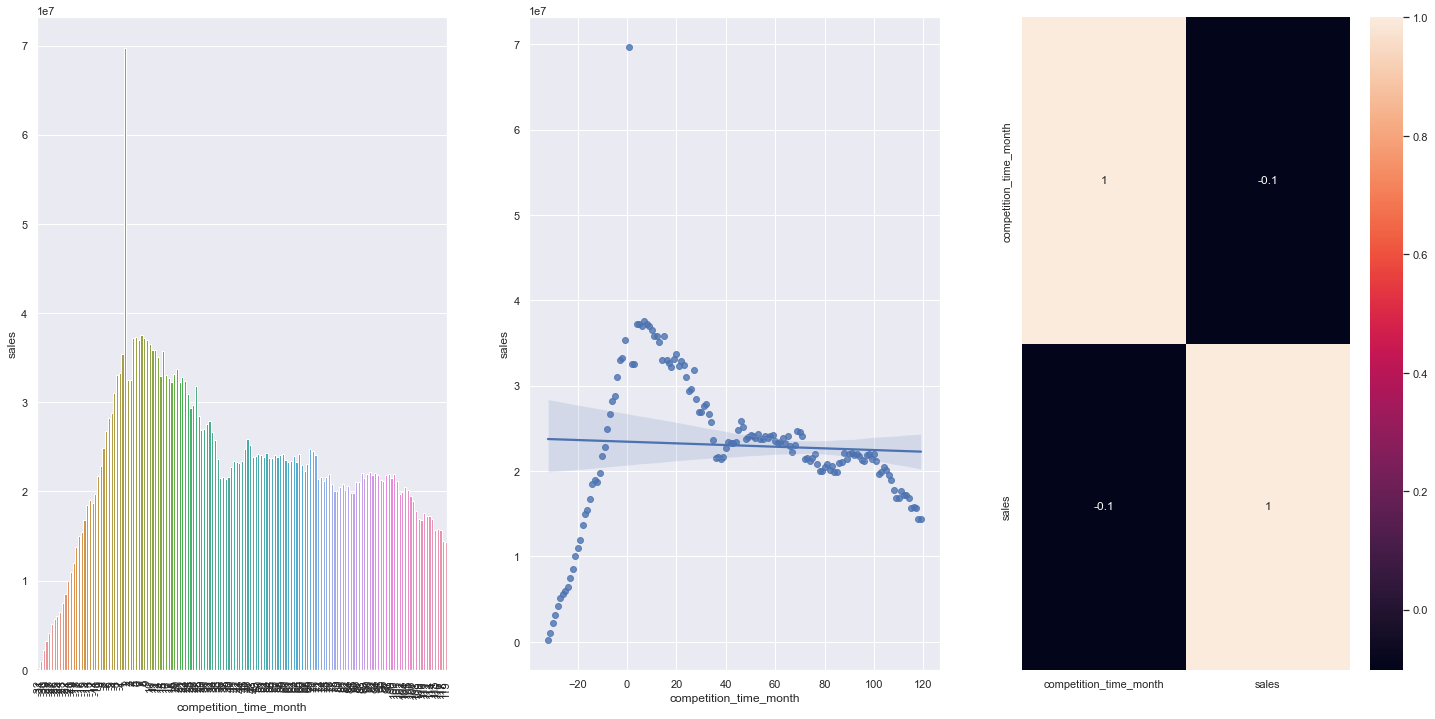

In [30]:
# barplot for sales in competition_time_month
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

# scatter for sales in competition_time_month
plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

# correlation sales - competition_time_month
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H4. Stores with active promotions for longer should sell more.¶

**False**. Stores with active promotions sell less after a certain duration.

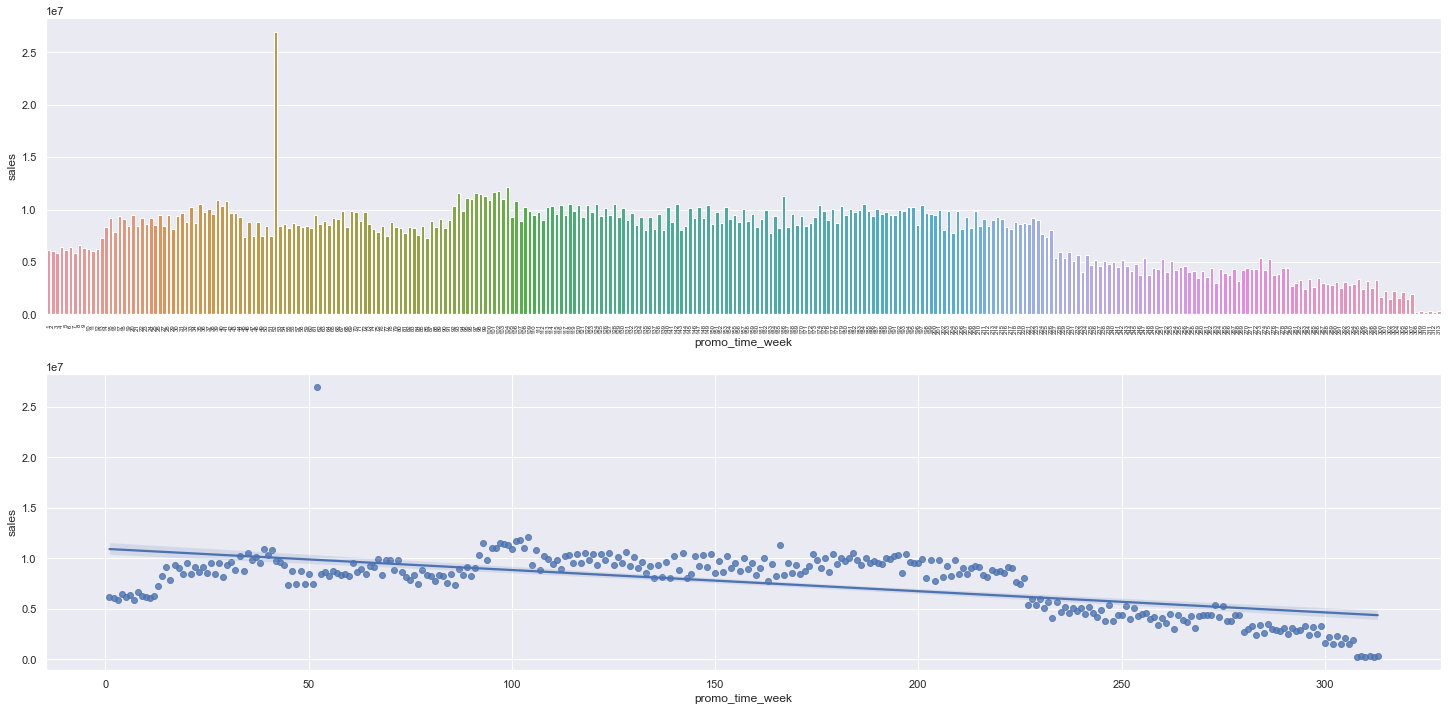

In [31]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

# extended promo period
plt.subplot(2,1,1)
aux2 = aux1[aux1['promo_time_week'] > 0] # extended period
sns.barplot(x = 'promo_time_week',y = 'sales', data = aux2);
plt.xticks(rotation = 90, fontsize = 6);

plt.subplot(2,1,2)
sns.regplot(x = 'promo_time_week',y = 'sales', data = aux2);

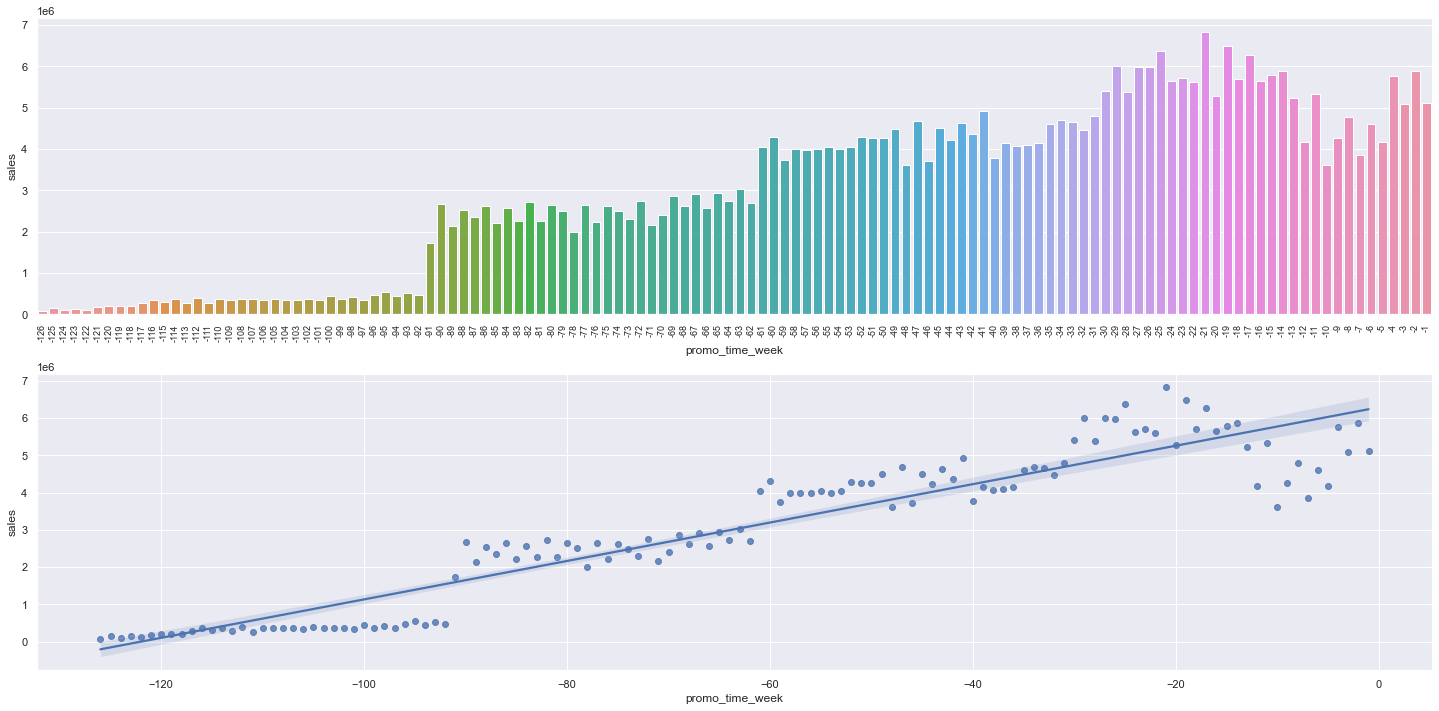

In [32]:
# regular promo period
plt.subplot(2,1,1)
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo
sns.barplot(x = 'promo_time_week',y = 'sales', data = aux3);
plt.xticks(rotation = 90, fontsize = 9);

plt.subplot(2,1,2)
sns.regplot(x = 'promo_time_week',y = 'sales', data = aux3);

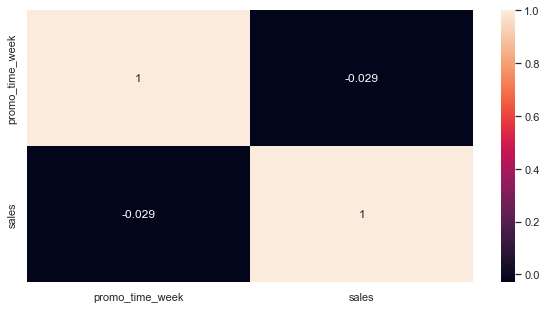

In [33]:
# correlation sales - promo_time_week
fig, ax = plt.subplots(figsize = (10,5))
sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = ax);

###  <s> H5. Stores with more promotion days should sell more. <s/>

### H6. Stores with more consecutive promotions should sell more.

**False**. Stores with more consecutive promotions sell less.

In [34]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


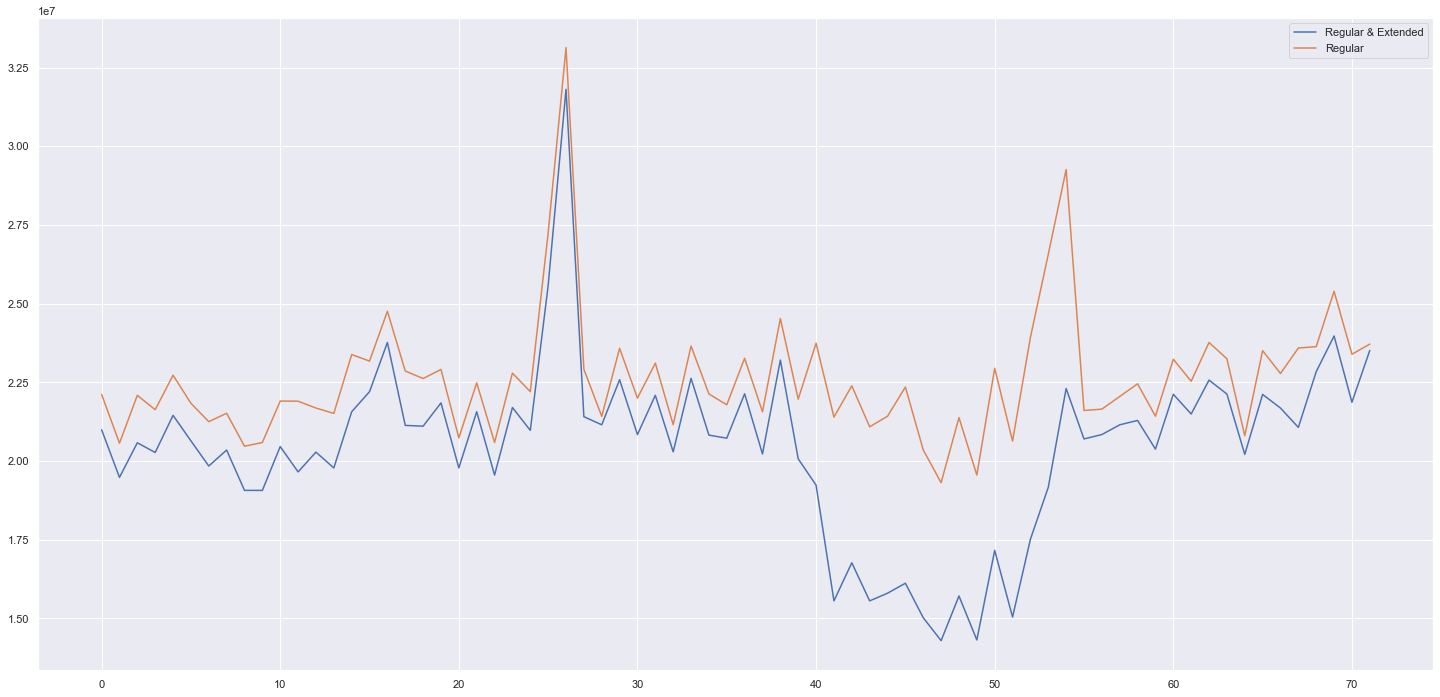

In [35]:
# regular and extended promo
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

# regular promo
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax);

ax.legend(labels = ['Regular & Extended', 'Regular']);

### H7. Stores that were opened during the Christmas holiday should sell more.

**False**. Stores open during the Christmas holiday sell less.

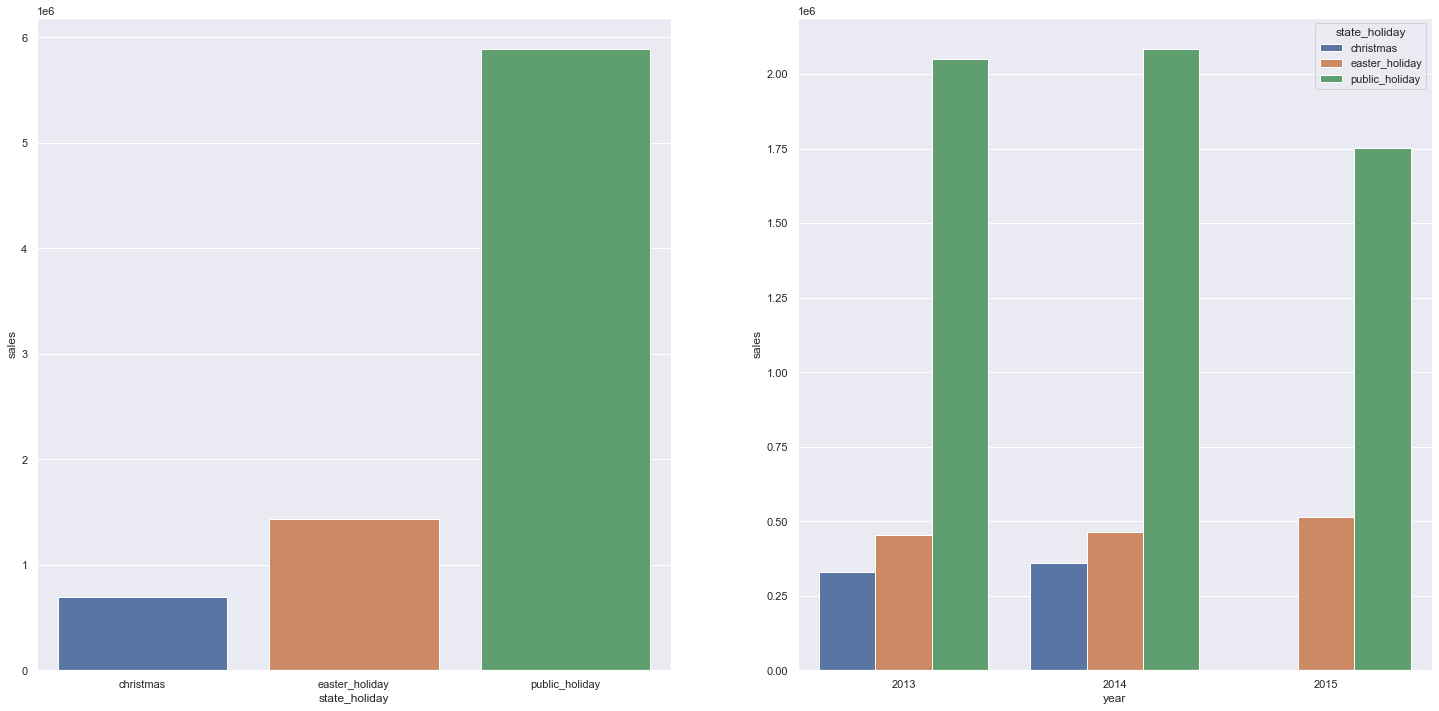

In [36]:
aux = df4[df4['state_holiday'] != 'regular_day']

# sales per holiday
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

# sales per holiday, year
plt.subplot(1, 2, 2)
aux1 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux1);

###  H8. Stores should sell more over the years.

**False**. Stores sell less over the years.

<AxesSubplot:>

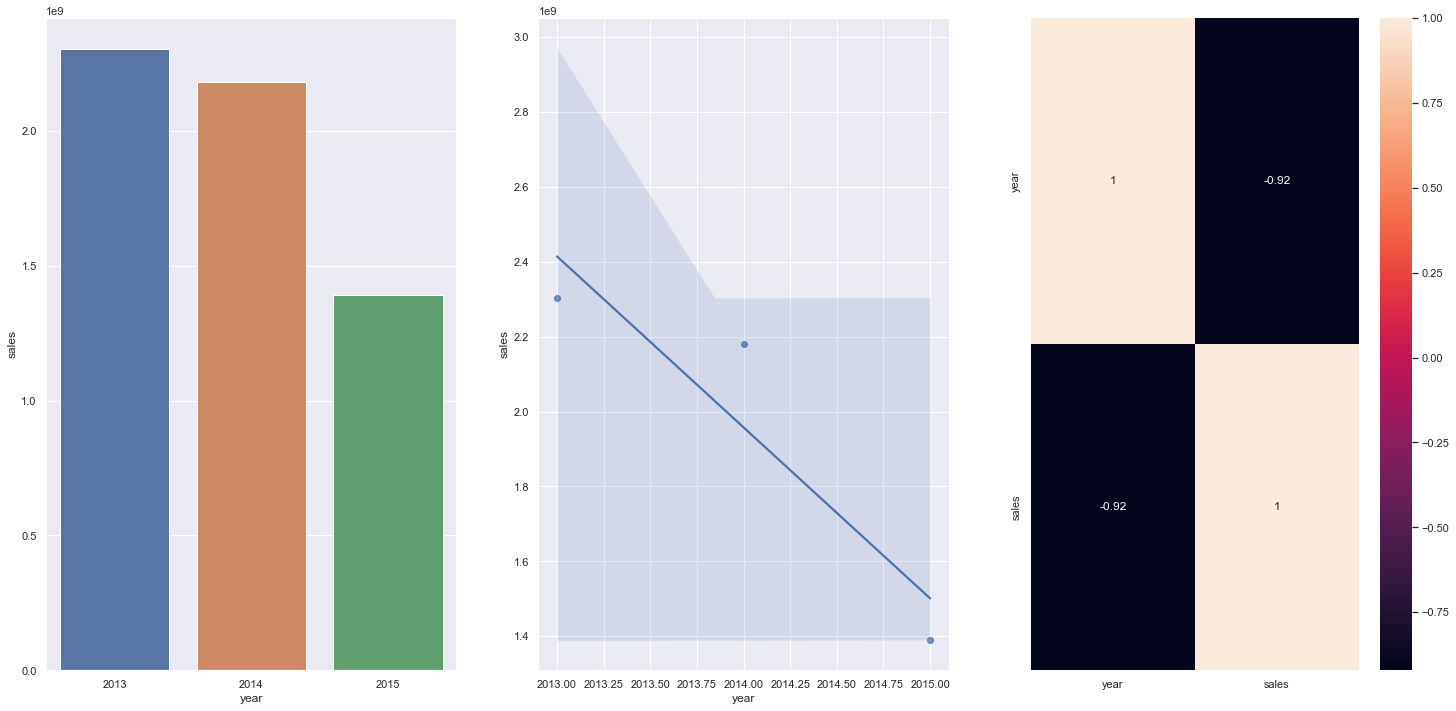

In [37]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

# bar plot sales per year
plt.subplot(1,3,1)
sns.barplot(x = 'year',y = 'sales', data = aux1)

# scatter plot sales per year
plt.subplot(1,3,2)
sns.regplot(x = 'year',y = 'sales', data = aux1)

# correlation year - sales
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### H9. Stores should sell more in the second half of the year.

**False**. Stores sell less in the second half of the year.

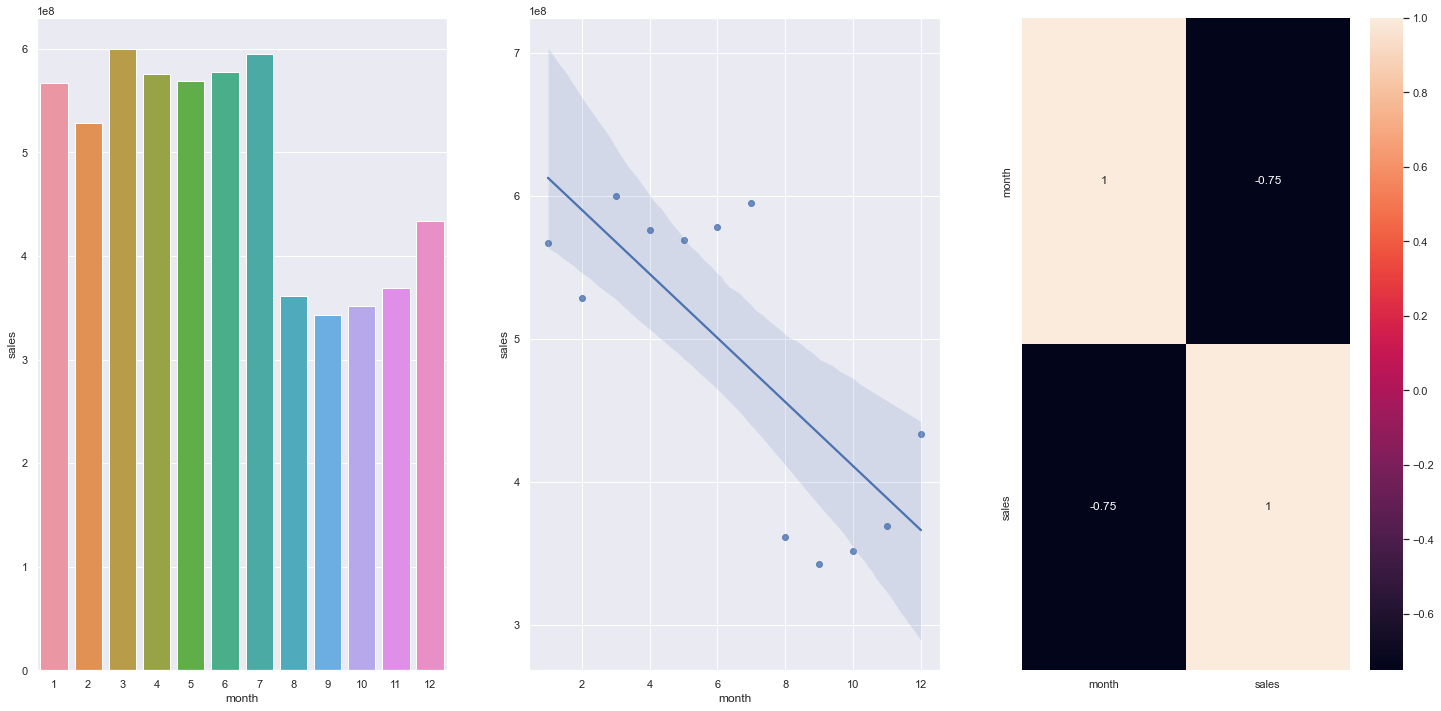

In [38]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

# bar plot sales per month
plt.subplot(1,3,1)
sns.barplot(x = 'month',y = 'sales', data = aux1);

# scatter plot sales per month
plt.subplot(1,3,2)
sns.regplot(x = 'month',y = 'sales', data = aux1);

# correlation month - sales
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H10. Stores should sell more after the 10th of each month.

**True**. Stores sell more after the 10th of each month.

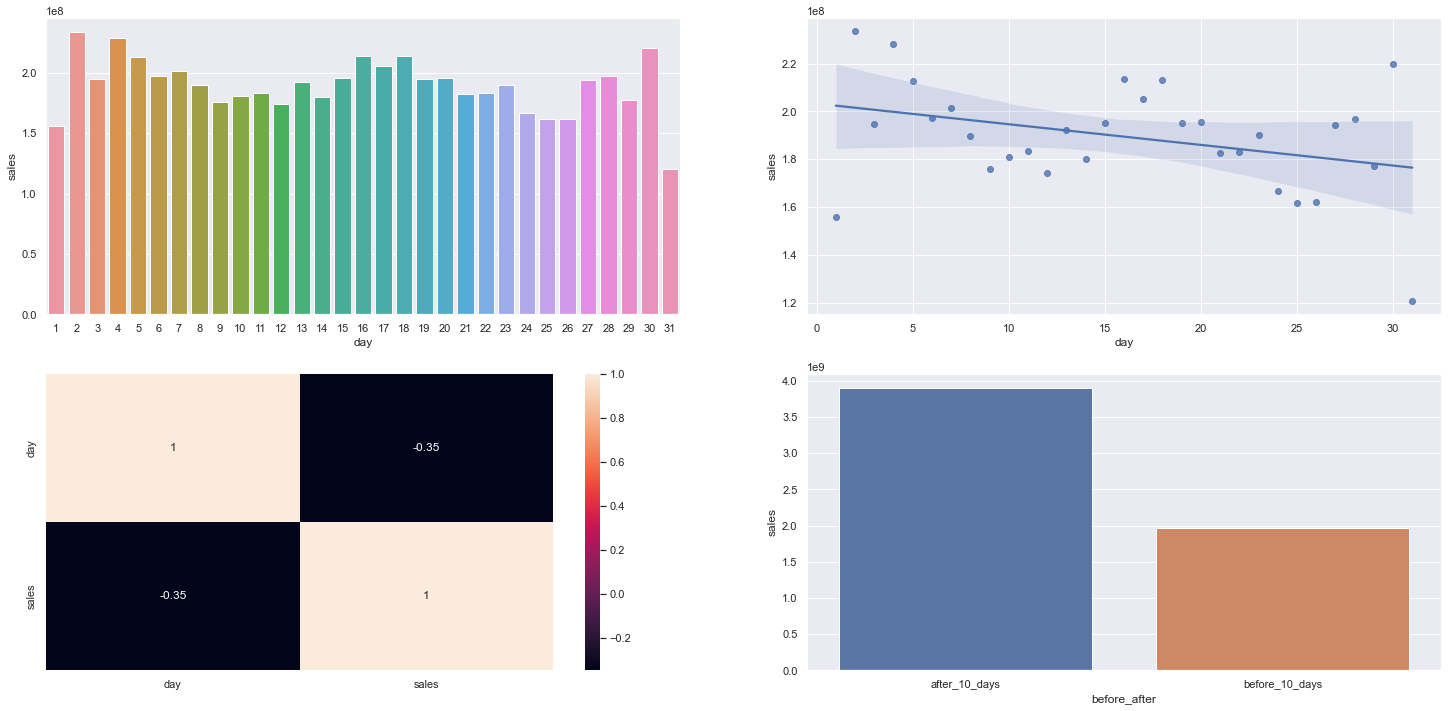

In [39]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

# bar plot sales per day
plt.subplot(2,2,1)
sns.barplot(x = 'day',y = 'sales', data = aux1);

# scatter plot sales per day
plt.subplot(2,2,2)
sns.regplot(x = 'day',y = 'sales', data = aux1);

# correlation day - sales
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

# bar plot sales before the 10th and after the 10th
plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2);

### H11. Stores should sell less on weekends.

**True**. Stores sell less on weekends.

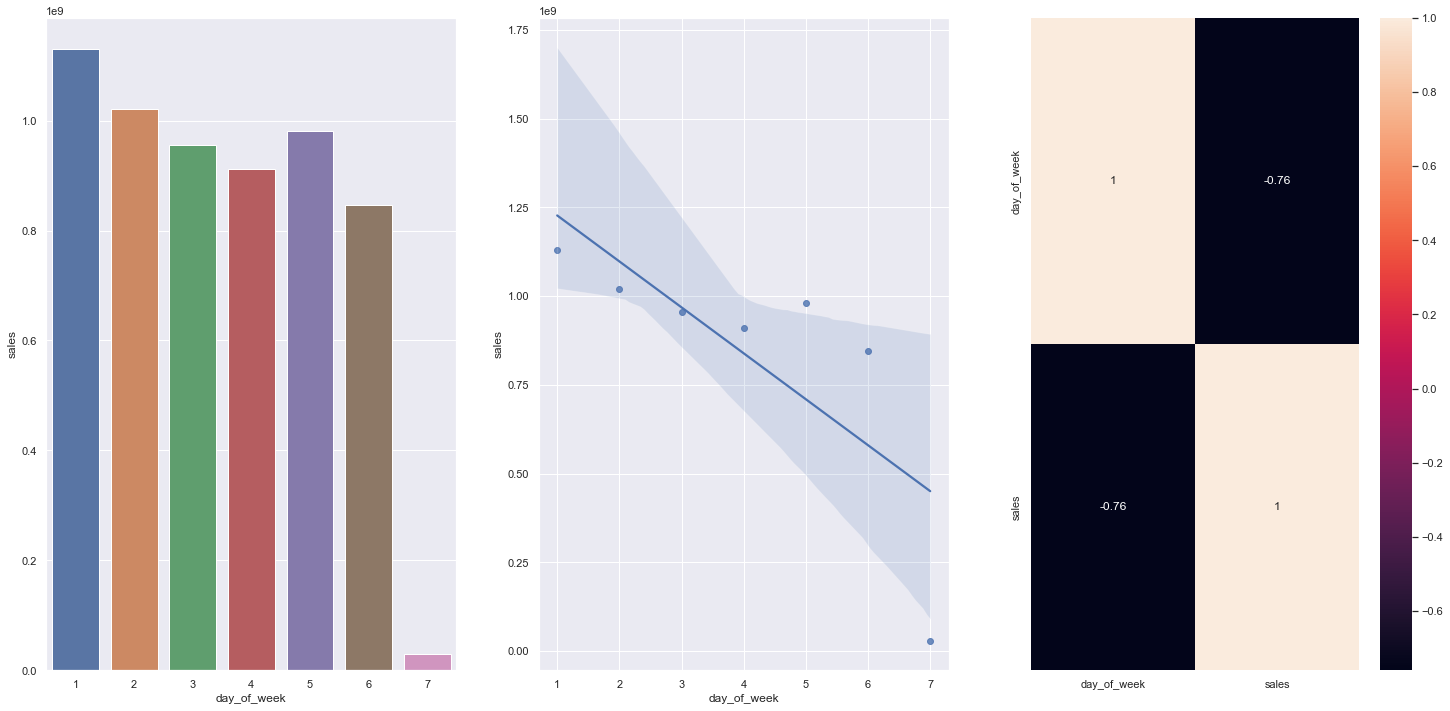

In [40]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

# bar plot sales per day of week
plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week',y = 'sales', data = aux1);

# scatter plot sales per day of week
plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week',y = 'sales', data = aux1);

# correlation sales - day of week
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H12. Stores should sell less during school holidays.

**True**. Stores sell less during school holidays except in July and August.

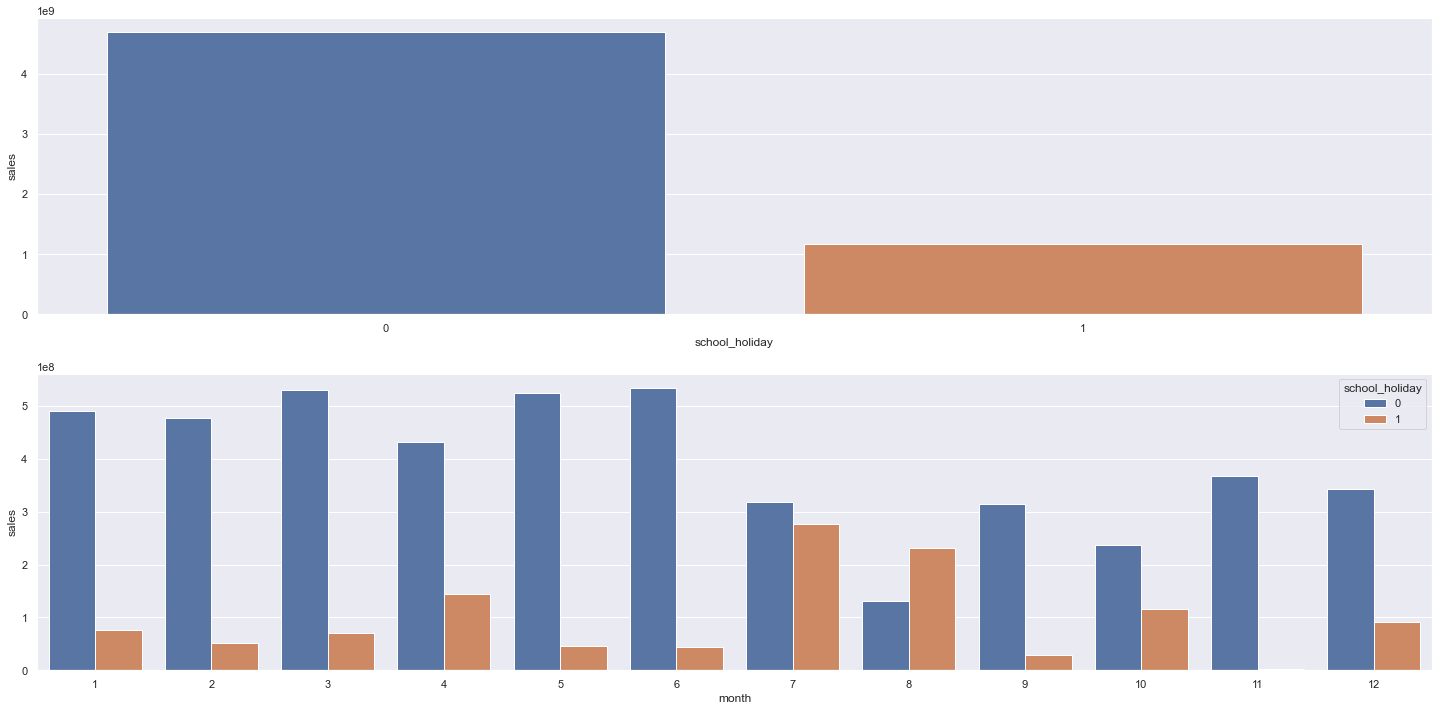

In [41]:
# bar plot sales per school_holiday
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday',y = 'sales', data = aux1);

# bar plot sales per school_holiday, month
plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month',y = 'sales',hue = 'school_holiday', data = aux2);

### 5.2.1. Hypotheses Summary

In [42]:
tab = [['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low']]

pd.DataFrame(tab, columns = ['Hypotheses', 'Conclusion', 'Relevance'])

,Hypotheses,Conclusion,Relevance
0,H1,False,Low
1,H2,False,Medium
2,H3,False,Medium
3,H4,False,Low
4,H5,-,-
5,H6,False,Low
6,H7,False,Medium
7,H8,False,High
8,H9,False,High
9,H10,True,High


## 5.3. Multivariate Analysis<a id='multivariate_analysis'></a>

This stage will be divided into two sections:

* Numeric attributes
* Categorical attributes

To check the correlation between numerical variables, we will use the **Pearson** method and for categorical variables, **Cramer's V** method.

### 5.3.1. Numerical Attributes

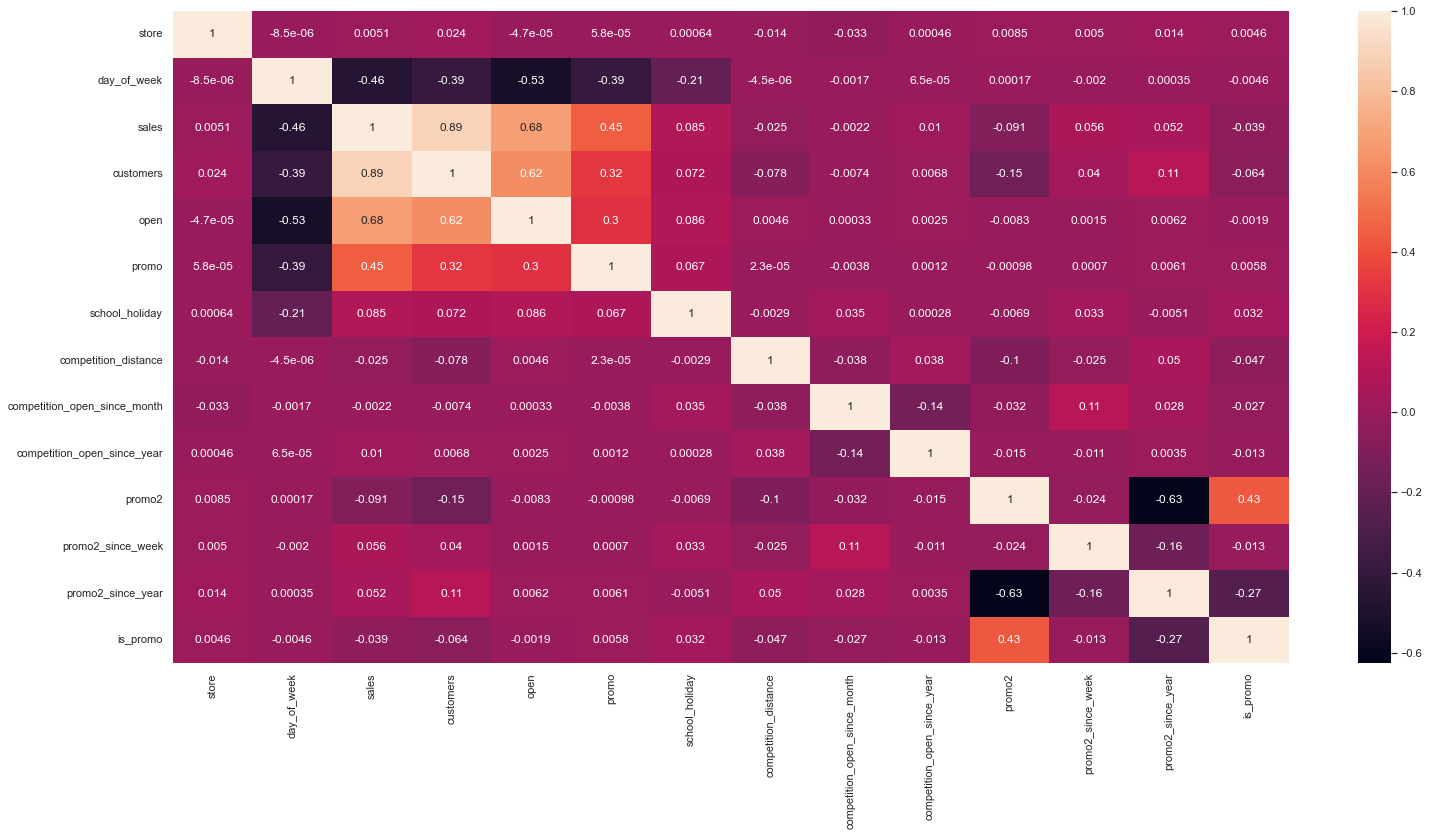

In [43]:
#separating numerical variables and building the heat map
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

The variables that have some dependence on the response variable are: "day_of_week", "open" and "promo". We also have the variable "customers", but we will not have this information when predicting sales, thus, it will be removed.

### 5.3.2. Categorical Attributes

In statistics, Cramer's V is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). Unlike Pearson's coefficient that goes from -1 to 1, Cramer's V goes from 0 to 1. In other words, there is no negative correlation in categorical variables. We can create a function to apply to all other columns.

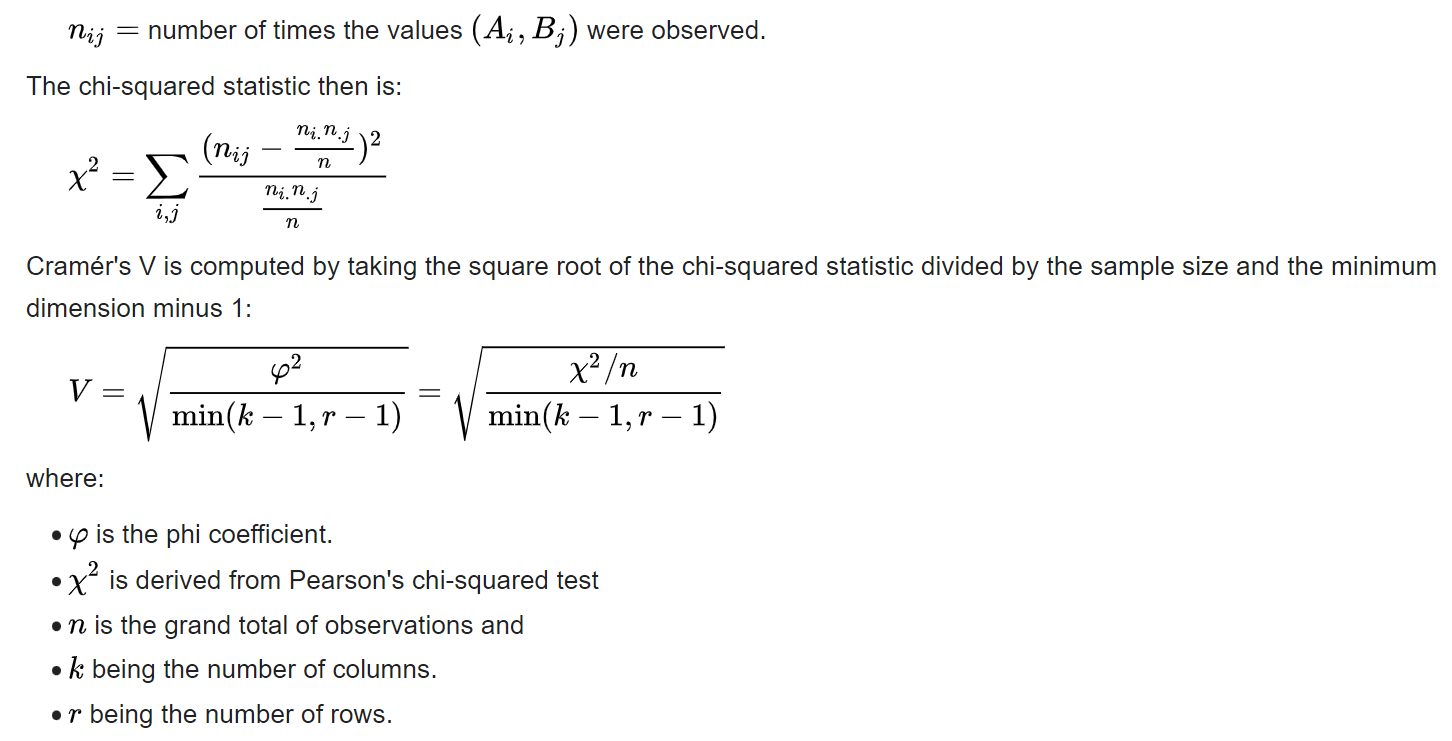

It is necessary to remember that we will need to modify our function a little, because Cramer's V has a very high bias and it may overestimate our analysis, being necessary to carry out the correction. 

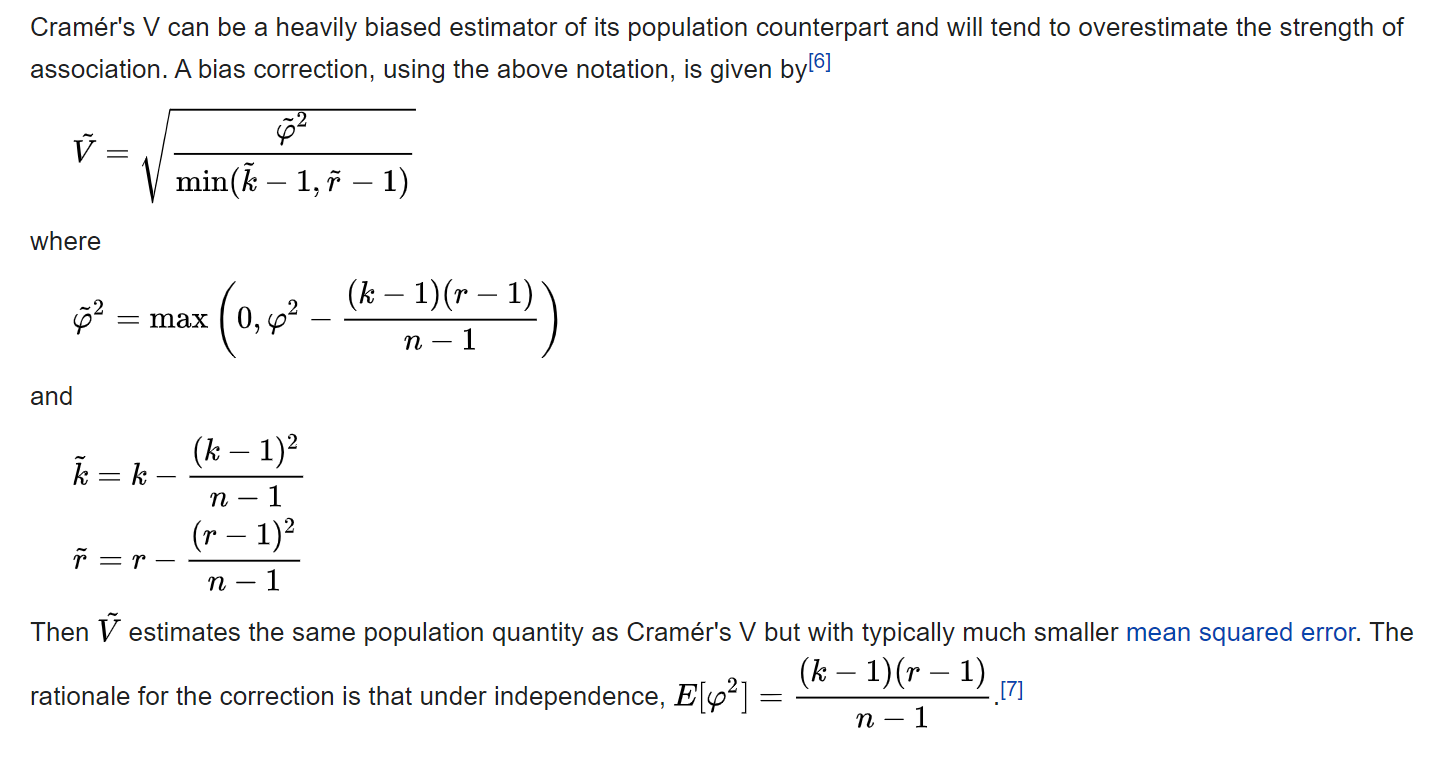

In [44]:
#only categorical data
a = df4.select_dtypes(include = 'object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


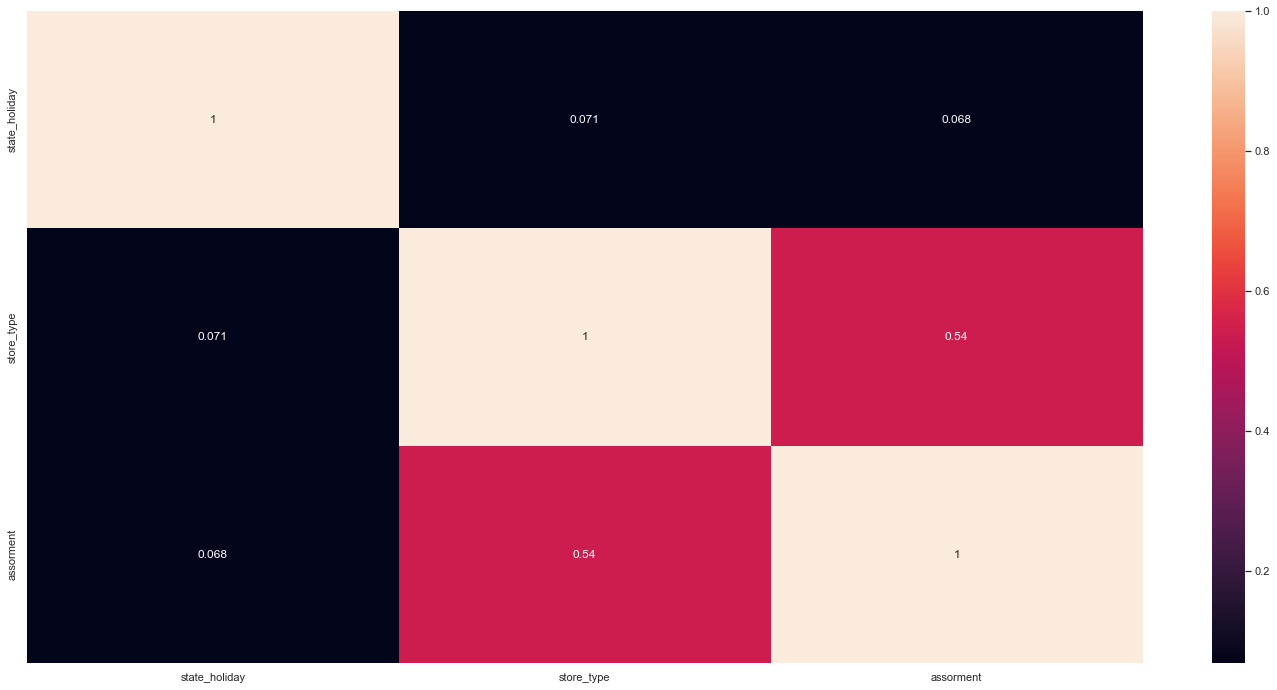

In [45]:
#calculate cramer v
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assorment': [a7,a8,a9]
             })

#final dataset
d = d.set_index(d.columns)
sns.heatmap(d , annot = True);